# Creating an Operational Tool for Census Transcription Workflows

So far we have developed two separate image processing tools for inspecting digitized images of census forms. These tools work together to look at the demographics columns in these census forms and focus effort on the target demographics that we care about. So far this amounts to a "W" detector, helping us to disregard any census forms that only record white families and focus transcription efforts on other pages. In order for this "W" detector to become useful in a workflow, we need to provide additional code that will handle some exceptional cases and provide code that will record the results of the "W" detector as it is used.

## Making Partial Predictions More Useful

There are several steps we can take that will make our predictions more useful in filtering data for manual transcription.

1. Filter out all of the known 'W' characters. There is no need to distract people with images of demographic cells that we are sure are 'W' characters.

1. Filter out all the cells where 'W' was a significant probability. Even though the model may predict another character is more likely than a 'W', we often see that a 'W' is in second place, in terms of probability. A quick review of these situations indicates that in most cases, with respect to our census demographic data, these second place 'W' predictions are correct. So we can probably filter out the cells where 'W' is the second most predicted character.

1. Our task is really to collect page references for further analysis by a human being, who will look at the whole page. If we can help a person focus on the few cells that may or may not contain a targetted demographic code ("Jap" is the demographic code for Japanese, in our case), then a person can either say yes or no to saving that page reference for further analysis. In other words, even though we may have up to 30 cell images to review, we only need one answer for the entire page, which is "save" or "ignore".

1. Lastly, we could use both (or more) models in tandem, the plain neural network and convolutional one. If any model predicts a "W" character, we can accept that conclusion. This seems pretty safe, as not many other demographic codes resemble a W and it should increase our chances or detecting all of the "W"s  on a page. Since employing multiple models at the same time will involve a deeper refactoring of our code, we save that step for the next notebook, where we will focus on operationalizing this tool within a transcription workflow.

Let's see if we can implement something like this in our *run()* function. First we will filter out all the known 'W' cells and cells where 'W' is a significant second place prediction, say greater than 15%.

## Handling Errors and Exceptional Cases

There are many images which may break the computer vision based segmentation tool or yeild strange results in the machine learning model. The machine learning model will likely always produce some error rate, so a little strangeness there is something we will have to work with. However, we cannot have these tools exiting with errors each time they come upon an image that doesn't match with the expected census pages. For instance the census population schedule folders also contain images of "cover sheets", which are much smaller pages that catalog a whole series of population schedule forms. We will need to add code that detects such pages and skips them.

We will probably also find some images that cannot be segmented with our computer vision approach, simply because they are too faded, folded, or otherwise made less legible. In those cases we probably need to let a user decide if the page is relevant for further study or not. We will need to know when the segmentation code has failed to produce a reasonable output and then take this other approach with the page image.

## User Interface and Transcription Workflow

This tool will be a sort of grand filter on census records for a particular city or region, allowing researchers to quickly eliminate a large number of pages from their manual transcription effort and analysis. When necessarily, it will need to prompt the user with images and ask whether a page should be saved for transcription or discarded. At the end of each run the tool will need to produce a list of saved and discarded pages, along with perhaps a code saying the reason for exclusion, i.e. was it "human review of entire page" or "tool decided" or "decided after partial human review" (of the non-white demographic codes). That way if someone want to revisit the decisions made, they can target their efforts. Since we are generally working in a data science environment in our workflows, we will output this information to a CSV file.

The first thing we will do is load some of our old code and trained models for use in this notebook.

In [1]:
import tensorflow as tf
import keras

# Load the models we trained in the previous notebook
dense_model = keras.saving.load_model("dense_model.keras")
conv_model = keras.saving.load_model("conv_model.keras")

# Load the segmentation code that we developed in that notebook
with open("segmentation.py") as f:
    code = f.read()
exec(code)

# Reusing this function to convert image pixel values to floating point between 0 and 1.
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

2024-11-09 15:17:03.464886: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 15:17:03.465085: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 15:17:03.467262: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 15:17:03.492427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 15:17:03.943719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Now let's simplify our run function, by "factoring out" a function that yeilds demographic cell images. This function will encapsulate all of the special logic regarding the census template and how to use the `extract()` function. A special keyword, `yield`, is used to return a series of results.

In [2]:
def get_demographic_cell_squares(image):
    (adjusted_img, v_lines, h_lines) = extract(image, f, debug=False)
    grayimage = cv2.cvtColor(adjusted_img,cv2.COLOR_BGR2GRAY)
    grayimage = 255 - grayimage
    demo_h_offset = v_lines[11]  # the demographic column starts the the 12th vertical line
    demo_width = v_lines[12] - demo_h_offset  # width calculation
    # Open CV rectangles calculation for each demographic cell
    demographic_cells = \
    [ (demo_h_offset, h_lines[i], demo_width, int(h_lines[i+1]-h_lines[i])) for i in range(3, len(h_lines)-1)]
    for i in range(3, len(h_lines)-1):
        cell_img = grayimage[h_lines[i]+5:h_lines[i+1]+5, v_lines[11]:v_lines[12]]
        yield crop_cell(cell_img)

Here then is our `run()` function with all of that segmentation logic moved out to the new yield function. It is a lot simpler to look at.

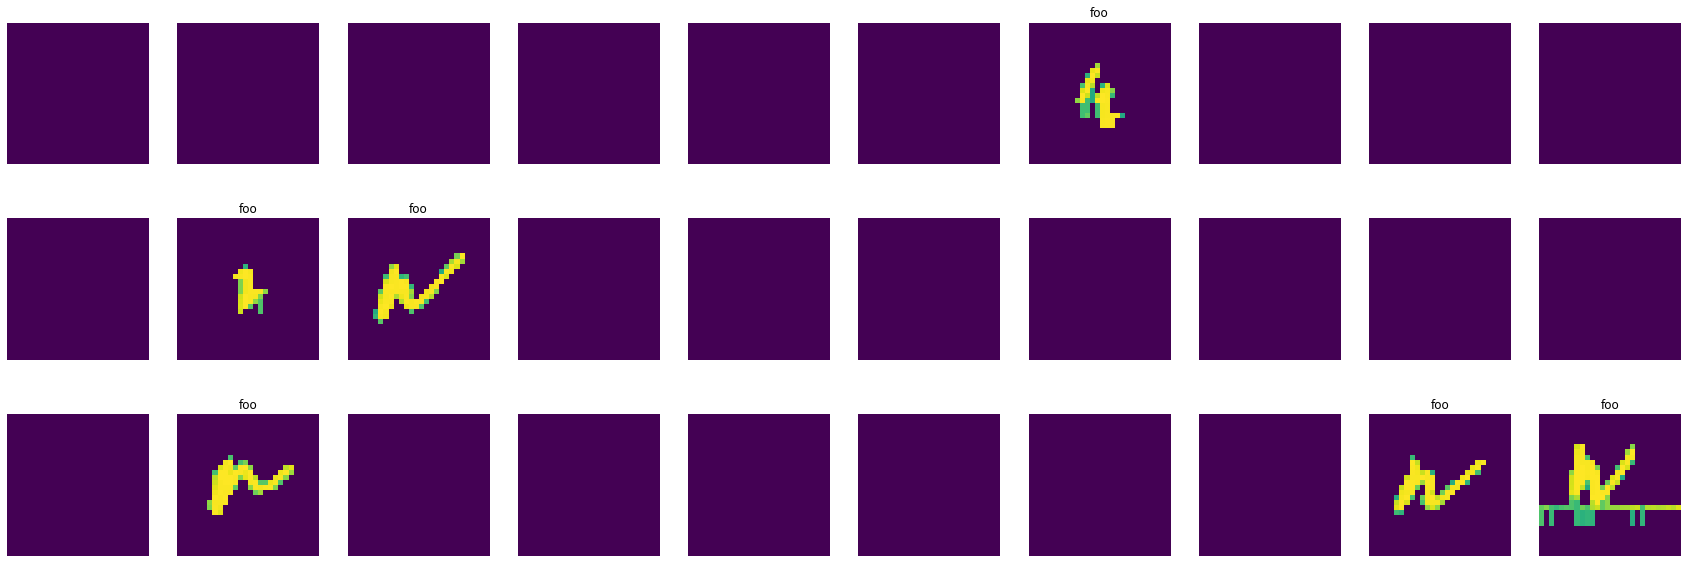

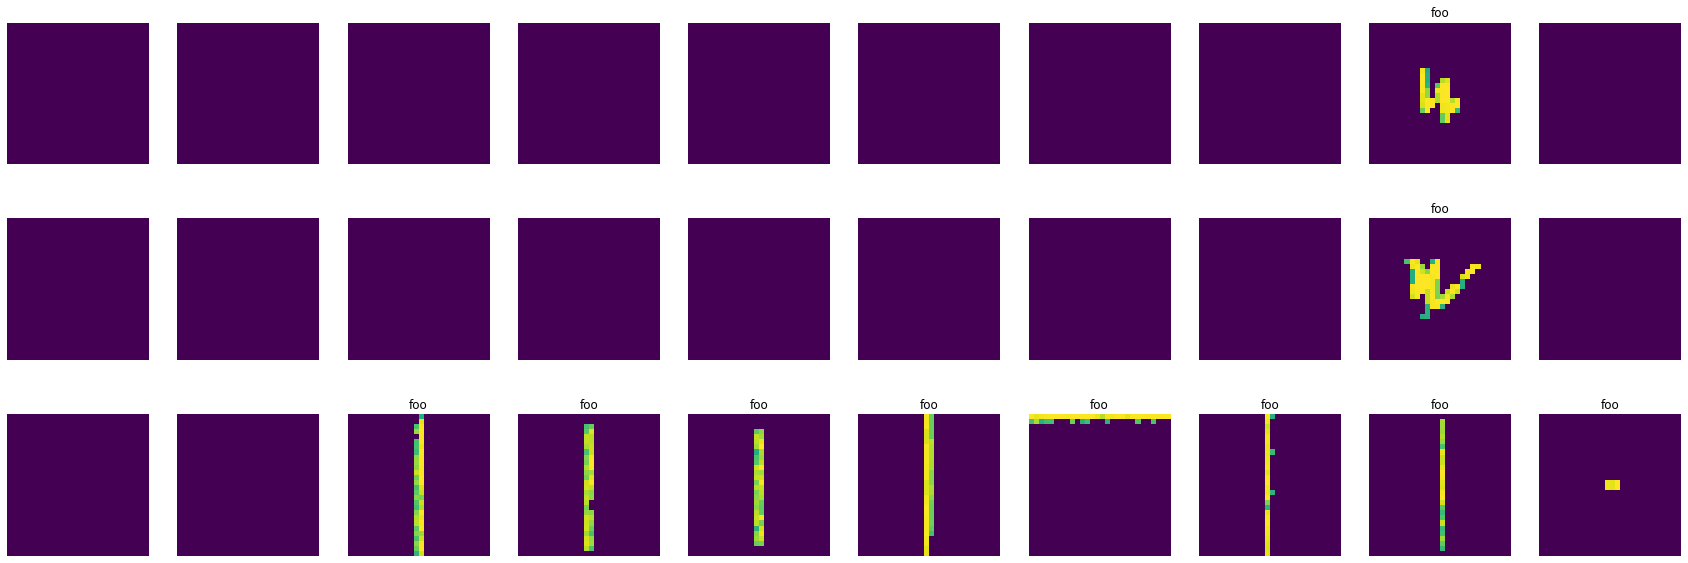

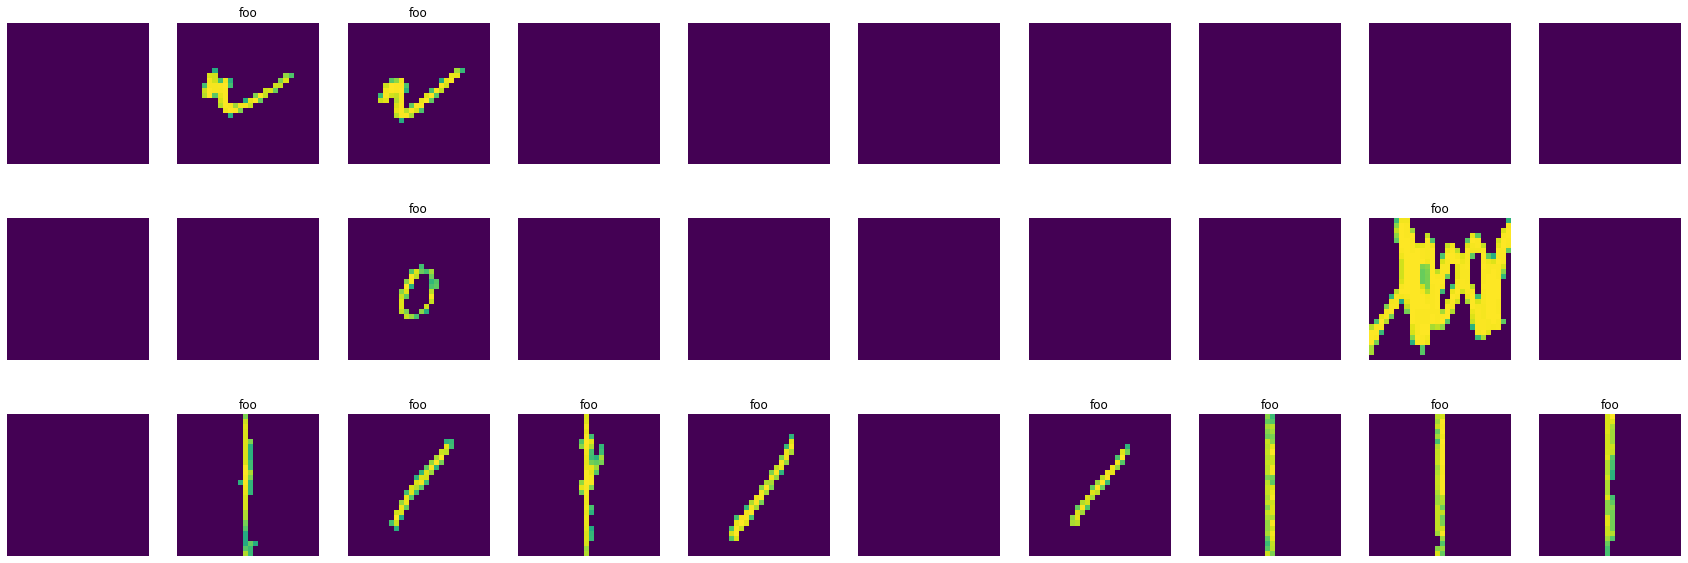

In [3]:
import glob
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np

lookup = list("abcdefghijklmnopqrstuvwxyz".upper())
blank = np.zeros((28,28, 1), dtype=np.uint8)

def run(path, page_range=(2, 16), models=[], debug=False):
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d+).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        fig = plt.figure(figsize=(30, 10))
        image = cv2.imread(f)
        for i, cell in enumerate(get_demographic_cell_squares(image)):
            ax = plt.subplot(3, 10, i+1)
            plt.axis('off')
            tensor, noop = normalize_img(cell, 0)
            is_W = False
            for model in models:
                result = model.predict(np.expand_dims(tensor, 0), verbose=0)
                classes_x=np.argmax(result,axis=1)
                prediction = int(classes_x[0])
                if prediction == 23 or result[0][23] >= .10:
                    is_W = True
                    break
            if is_W:
                plt.imshow(blank)
            else:
                ax.set(facecolor="orange")
                plt.imshow(cell)
                plt.title("foo")

run('pages', page_range=(14,17), models=[dense_model, conv_model])

From this code output above you can probably see that we are getting fewer non-W's detected due to our use of two trained models at once to screen out the W's. The code is simpler to look at, which is good because now we have to add some more features to it. First let's stop looking at all of these blank images that are hiding the known W cells. Instead let's make plots that only show the remaining cells that need human review.

In [4]:
import glob
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np

lookup = list("abcdefghijklmnopqrstuvwxyz".upper())
blank = np.zeros((28,28, 1), dtype=np.uint8)
plt.ioff()

def run(path, page_range=(2, 16), models=[], debug=False):
    review_page_cells = []
    review_page_filenames = []
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d+).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        image = cv2.imread(f)
        review_cells = []
        for i, cell in enumerate(get_demographic_cell_squares(image)):
            tensor, noop = normalize_img(cell, 0)
            is_W = False
            for model in models:
                result = model.predict(np.expand_dims(tensor, 0), verbose=0)
                classes_x=np.argmax(result,axis=1)
                prediction = int(classes_x[0])
                if prediction == 23 or result[0][23] >= .10:
                    is_W = True
                    break
            if is_W:
                pass
            else:
                review_cells.append(cell)
        if len(review_cells) == 0:
            continue
        else:
            review_page_cells.append(review_cells)
            review_page_filenames.append(f)
        
        if len(review_page_cells) == 8:
            for n, page_cells in enumerate(review_page_cells):
                fig = plt.figure(figsize=(30, 1))
                fig.suptitle(review_page_filenames[n])
                for i, cell in enumerate(page_cells):
                    plt.subplot(1, len(page_cells), i+1)
                    plt.axis('off')
                    plt.imshow(cell)
                display(fig)
            review_page_cells = []
            review_page_filenames = []

run('pages', page_range=(4,17), models=[dense_model, conv_model])

ValueError: attempt to get argmax of an empty sequence

Okay, this is a little easier to review. I can quickly scan these images and see that none of these are from pages that I would want to save for transcription. The next question is how do we create this interaction of saving a page for later. I think ideally one would look at a screen full of cell images in need of review. If any of the cells within a page are marked "Jap" for Japanese, you would click on the "save" button for that page. When done reviewing the whole screen you would "hit enter" or some equivalent to get a fresh page of cell images. This is a fairly sophisticated interaction for a notebook, but I think we can manage it. The next code block will introduce the screen by screen display feature.

## Rendering a User Interface

IPython is an interactive Python framework that underlies the JupyterLab notebook environment. You can use [IPython "widgets"](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Basics.html) to add more complex controls to your cell outputs. We will use controls such as these to add interactivity and paging to our tool. We will need to review several pages of uncertain demographic cells at once, check a box to indicate if any pages need manual review and/or transcription, then advance to the next screen.
When the user advances to the next screen, we want to save any pages that were marked for manual review or transcription to a file. In the code block below you will see some of these controls and interactions illustrated using dummy data. It is much easier to develop the controls this way before we fold them into our real data outputs.

In [23]:
from IPython.display import display
import ipywidgets as widgets

boxes = {}
review_file = "to_be_reviewed.txt"

def chkbox(page_file):
    global boxes
    chkbox1 = widgets.Checkbox(value=False, description=f"Save {page_file}")
    boxes[chkbox1] = page_file
    return chkbox1

button = widgets.Button(description="Next Screen")
output = widgets.Output()
with output:
    display(chkbox('page_1.png'))
    display(chkbox('page_2.png'))
    display(button)

display(output)

def on_button_clicked(b):
    global boxes
    saved = []
    for box in boxes.keys():
        if box.value:
            saved.append(boxes[box])
        else:
            pass
    print(f"Next screen clicked with {len(saved)} page files saved.")

button.on_click(on_button_clicked)

Output()

Next screen clicked with 2 page files saved.


Above you can see how we used our checkbox controls as the keys in a global dictionary. This allows us to lookup the page file associated with each checkbox and act accordingly. For now we simply print out some information, but we will need to save any applicable page file references into another file. Let's add the save function now and test it.

In [26]:
from IPython.display import display
import ipywidgets as widgets

boxes = {}
review_file = "to_be_reviewed.txt"

def chkbox(page_file):
    global boxes
    chkbox1 = widgets.Checkbox(value=False, description="Save")
    boxes[chkbox1] = page_file
    return chkbox1

button = widgets.Button(description="Next Screen")
output = widgets.Output()
with output:
    display(chkbox('page_1.png'))
    display(chkbox('page_2.png'))
    display(button)

display(output)

def on_button_clicked(b):
    global boxes
    global review_file
    saved = []
    for box in boxes.keys():
        if box.value:
            saved.append(boxes[box])
        else:
            pass
    with open(review_file, mode="a") as wf:
        for f in saved:
            wf.write(f'{f}\n')
    boxes = {}
    print(f"Next screen clicked with {len(saved)} page files saved.")

button.on_click(on_button_clicked)

Output()

Next screen clicked with 1 page files saved.


Great! You can verify that any checkbox selections are appended to our save file, `to_be_reviewed.txt`.

The next step is to be able to clear the screen and render a new set of checkboxes.. We will be called a `clear()` function of the output widget.

In [1]:
from IPython.display import display
import ipywidgets as widgets

boxes = {}
review_file = "to_be_reviewed.txt"
output = widgets.Output()

def chkbox(page_file):
    global boxes
    chkbox1 = widgets.Checkbox(value=False, description=f'Save {page_file}')
    boxes[chkbox1] = page_file
    return chkbox1

def on_button_clicked(b):
    global boxes
    global review_file
    saved = []
    for box in boxes.keys():
        if box.value:
            saved.append(boxes[box])
        else:
            pass
    with open(review_file, mode="a") as wf:
        for f in saved:
            wf.write(f'{f}\n')
    boxes = {}
    render_page()
    print(f"Next screen clicked with {len(saved)} page files saved.")

def render_page():
    global output
    if output is not None:
        output.clear_output()
    button = widgets.Button(description="Next Screen")
    with output:
        vbox = widgets.VBox([chkbox('page_1.png'), chkbox('page_2.png'), button])
        display(vbox)
    button.on_click(on_button_clicked)

render_page()
display(output)



Output()

Next screen clicked with 1 page files saved.


Next screen clicked with 1 page files saved.


Next screen clicked with 1 page files saved.


## Integrating the User Interface with the Image Processing Takes

Our next step is a bigger one. We want to use the screen by screen save interface to review processed demographic cell images. This means combining two sets of code, a complex task. We will be glad that we simplified our image processing code a few steps back. In addition to putting our code together, we want to design the program such that image processing can proceed while a person is performing their review task. This will mean that subsequent screens, after the first, should load faster without waiting for as many image operations to complete. We will accomplish this by adding another "thread" or "worker" to the program. Our kernel will have two threads running, one responding to input and another working away at image tasks. The will cooperate through a special structure called a queue, which is basically a special kind of list. The queue we will use is "first in, first out" or FIFO. This means that while new items are inserted at the head of the queue, the earliest items that were inserted are taken from the tail of the queue. Our image thread will add information about pages and lists of demographic cells to the queue, while our user interface code will remove these items and show them to users. Note that because we have two threads accessing the same structure we need to take care that the queue is "synchronized", which means that it is protected from failures that result from multi-threaded access and modification. We will use the queue library which provides synchronized queues.

In [ ]:
import glob
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np
from queue import Queue
import threading
import time

q = Queue(maxsize=5)
sentinel = object()

lookup = list("abcdefghijklmnopqrstuvwxyz".upper())
blank = np.zeros((28,28, 1), dtype=np.uint8)
plt.ioff()

def run(path, page_range=(2, 16), models=[], debug=False):
    global q
    global image_processing_done
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d*).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        image = cv2.imread(f)
        review_cells = []
        for i, cell in enumerate(get_demographic_cell_squares(image)):
            tensor, noop = normalize_img(cell, 0)
            is_W = False
            for model in models:
                result = model.predict(np.expand_dims(tensor, 0), verbose=0)
                classes_x=np.argmax(result,axis=1)
                prediction = int(classes_x[0])
                if prediction == 23 or result[0][23] >= .10:
                    is_W = True
                    break
            if is_W:
                pass
            else:
                review_cells.append(cell)
        if len(review_cells) == 0:
            continue
        else:
            # Add page to the queue
            page = { 'file': f, 'review_cells': review_cells }
            q.put(page, block=True)  # imaging thread will "block" or wait here until space is available in the queue..
    q.put(sentinel, block=True)


Adding pages/43290879-California-101393-0004.jpeg to queue.
Adding pages/43290879-California-101393-0005.jpeg to queue.
Adding pages/43290879-California-101393-0006.jpeg to queue.
Adding pages/43290879-California-101393-0007.jpeg to queue.
Size of queue: 4
First item: pages/43290879-California-101393-0004.jpeg
Thread is alive? True
pages/43290879-California-101393-0005.jpeg
pages/43290879-California-101393-0006.jpeg
pages/43290879-California-101393-0007.jpeg
Adding pages/43290879-California-101393-0008.jpeg to queue.
pages/43290879-California-101393-0008.jpeg
Adding pages/43290879-California-101393-0009.jpeg to queue.
pages/43290879-California-101393-0009.jpeg
Adding pages/43290879-California-101393-0010.jpeg to queue.
pages/43290879-California-101393-0010.jpeg
Adding pages/43290879-California-101393-0011.jpeg to queue.
pages/43290879-California-101393-0011.jpeg
Adding pages/43290879-California-101393-0012.jpeg to queue.
pages/43290879-California-101393-0012.jpeg
Adding pages/43290879-

In [ ]:
def start():
    run('pages', page_range=(4,17), models=[dense_model, conv_model])

thread2 = threading.Thread(target=start, daemon=True)
thread2.start()
time.sleep(10)
print(f'Size of queue: {q.qsize()}')
file_path = q.get(block=False)['file']
print(f'First item: {file_path}')  # We set block to False so that we can an exception, instead of waiting for an item to join the queue.
print(f'Thread is alive? {thread2.is_alive()}')

for p in iter(q.get, sentinel):
    file_path = p['file']
    print(file_path)

Okay, so above we have two threads; the one that is running our code in the first place and the one that we started using the Thread object. When I ran this code the queue was completely full, containing five pages, by the time our foreground thread woke up from sleep and accessed it. The speed of your computer may yield different results. Now that this seems to be working, we will go ahead and increase the queue size to 40 pages and rewrite the user interface code to pull items from the queue.

In this code we are using a special for matplotlib figure integration into the notebook widget framework. It is included via a special notebook **magic** command in the first line. This allows us to embed the demographic cell figures into a more carefully crafted user interface.

First I will make a few edits to the run method, so that I can gather more information and show the whole demographic cell when a W is not recognized, instead of the 28x28 image.

In [1]:
import tensorflow as tf
import keras

# Load the models we trained in the previous notebook
dense_model = keras.saving.load_model("dense_model_2.keras")
conv_model = keras.saving.load_model("conv_model_2.keras")

# Load the segmentation code that we developed in that notebook
with open("segmentation.py") as f:
    code = f.read()
exec(code)

# Reusing this function to convert image pixel values to floating point between 0 and 1.
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

2024-11-10 13:50:49.320475: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 13:50:49.320698: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 13:50:49.323027: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 13:50:49.348104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 13:50:49.796187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
def get_demographic_cell_squares(image):
    (adjusted_img, v_lines, h_lines) = extract(image, f, debug=False)
    grayimage = cv2.cvtColor(adjusted_img,cv2.COLOR_BGR2GRAY)
    grayimage = 255 - grayimage
    demo_h_offset = v_lines[11]  # the demographic column starts the the 12th vertical line
    demo_width = v_lines[12] - demo_h_offset  # width calculation
    # Open CV rectangles calculation for each demographic cell
    demographic_cells = \
    [ (demo_h_offset, h_lines[i], demo_width, int(h_lines[i+1]-h_lines[i])) for i in range(3, len(h_lines)-1)]
    for i in range(3, len(h_lines)-1):
        cell_img = grayimage[h_lines[i]+5:h_lines[i+1]+5, v_lines[11]:v_lines[12]]
        yield crop_cell(cell_img), cell_img

In [3]:
import glob
import matplotlib.pyplot as plt
import re
import cv2
import numpy as np
from queue import Queue
import threading
import time

q = Queue(maxsize=40)
sentinel = object()

lookup = list("abcdefghijklmnopqrstuvwxyz".upper())
blank = np.zeros((28,28, 1), dtype=np.uint8)
w_index = 1  # The index of the W category. We are testing yes/no and full alphabet categories..
# w_index = 23
w_acceptable_prob = 0.01
# w_acceptable_prob = .10

def run(path, page_range=None, models=[], debug=False):
    global q
    global image_processing_done
    global w_index
    for f in sorted(glob.glob(f'{path}/**/Schedule_Images/*.jpg', recursive=True)):
        pagestr = re.search(r'-(\d*).jpg', f).group(1)
        if page_range is not None and int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        if page_range is None and int(pagestr) == 1:
            continue
        #print(f'processing page {f}')
        image = cv2.imread(f)
        review_cells = []
        try:
            for i, (cell, cell_view) in enumerate(get_demographic_cell_squares(image)):
                tensor, noop = normalize_img(cell, 0)
                is_W = False
                for model in models:
                    result = model.predict(np.expand_dims(tensor, 0), verbose=0)
                    if result[0] >= w_acceptable_prob:
                        is_W = True
                        break
                if is_W:
                    pass
                else:
                    review_cells.append(cell_view)
            page = { 'file': f, 'review_cells': review_cells }
            q.put(page, block=True)  # imaging thread will "block" or wait here until space is available in the queue..
        except Exception as e:
            with open("image_errors.json", mode="a") as wf:
                data = {}
                data['file'] = f
                data['error'] = str(e)
                wf.write(f'{json.dumps(data)}\n')
    q.put(sentinel, block=True)


In [4]:
%matplotlib widget

from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import json

boxes = {}
screen_start_time = None
review_file = "to_be_reviewed.txt"
output = widgets.Output()

def chkbox(page_file, reviewed_count):
    global boxes
    chkbox1 = widgets.Checkbox(value=False, description=page_file)
    boxes[chkbox1] = {"file": page_file, "reviewed_count": reviewed_count}
    return chkbox1

def on_button_clicked(b):
    global boxes
    global review_file
    global screen_start_time
    etime = time.time() - screen_start_time
    with open(review_file, mode="a") as wf:
        for box in boxes.keys():
            data = boxes[box]
            data['screen_time'] = etime
            data['save'] = box.value
            wf.write(f'{json.dumps(data)}\n')
    boxes = {}
    render_page()

def render_page():
    global output
    global screen_start_time
    if output is not None:
        output.clear_output()
    plt.close('all')
    with output:
        page_count = 0
        vbox = []
        for p in iter(q.get, sentinel):
            fig = None
            with plt.ioff():
                fig = plt.figure(figsize=(16, 1.3),  label='')
                fig.canvas.header_visible = False
                fig.canvas.toolbar_visible = False
                fig.suptitle('')
                # Note: review cells are populated on 2nd screen..
                for i, cell in enumerate(p['review_cells']):
                    plt.subplot(1, len(p['review_cells']), i+1)
                    plt.axis('off')
                    plt.imshow(cell)  # TODO fix display
            layout = widgets.AppLayout(left_sidebar=chkbox(p['file'], len(p['review_cells'])), center=fig.canvas, pane_widths=['135px', 16, 0],)
            # NOTE: Next four lines due to ipympl issue: https://github.com/matplotlib/ipympl/issues/290
            fig.canvas._handle_message(fig.canvas, {'type': 'send_image_mode'}, [])
            fig.canvas._handle_message(fig.canvas, {'type':'refresh'}, [])
            fig.canvas._handle_message(fig.canvas,{'type': 'initialized'},[])
            fig.canvas._handle_message(fig.canvas,{'type': 'draw'},[])
            vbox.append(widgets.Text(value=f"{p['file']}  {30 - len(p['review_cells'])} Ws removed", layout=widgets.Layout(width='100%')))
            vbox.append(layout)
            page_count += 1
            if page_count >= 6:
                break  # showing 6 pages per screen
        if page_count > 0:
            button = widgets.Button(description="Next Screen")
            button.on_click(on_button_clicked)
            vbox.append(button)
        else:
            done = widgets.Text(value="Done with images (TODO stats here)", description="Done")
            vbox.append(done)
        display(widgets.VBox(vbox))
    screen_start_time = time.time()

def start():
    run('NARA_downloads_1950/70-150', page_range=None, models=[dense_model, conv_model])

page_slicer = threading.Thread(target=start, daemon=True)
page_slicer.start()
display(output)
render_page()



Output()

Things to do next:

* Nonetype object not subscriptable -  this happens when no dark vertical line matches the given kernel
* Isolate the images that produce this issue and test a more forgiving kernel shape.
* "NARA_downloads_1950/70-12/Schedule_Images/43290879-California-101300-0025.jpg" gives "float division by zero"



In [3]:
import json
with open('log.csv', mode='a') as out:
    with open('to_be_reviewed.txt', mode="r") as inp:
        for line in inp:
            data = json.loads(line)
            out.write(f'"{data["file"]}", "{data["reviewed_count"]}", "{data["screen_time"]}"\n')